## Name: David Ryan
## ID: 0867284

# Lab 3: Clustering and Manifold Learning

This notebook demonstrates:
- the k-Means clustering algorithm
- the use of manifold-learning techniques to project a clustered dataset into a 2D space and visualise it as a scatterplot

It is assumed that the input dataset contains ___only numerical___ attributes. To use this code with a dataset that contains categorical attributes, they first need to be _somehow_ transformed to numerical. How categorical attributes can be represented as numerical may depend on the nature of the dataset.

When you go through this notebook for the first time you may __skip section C__ and go back to it at the end.

### A. Import Python Modules and Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

from sklearn import manifold #needed for multidimensional scaling (MDS) and t-SNE
from sklearn import cluster #needed for k-Means clustering
from sklearn import preprocessing #needed for scaling attributes to the nterval [0,1]
from sklearn.metrics import silhouette_score

#### Load the dataset

In [2]:
df = pd.read_csv("./loans_train_prepared-1.csv")
data = np.array(df.values, dtype=float)
print('(number of examples, number of attributes): ', data.shape)

(number of examples, number of attributes):  (614, 16)


### B. Rescale the Data
Here we rescale the values in each column to the interval $[0,1]$ with MinMaxScaler. Please note that if your dataset is already prepared for ML there is no need to rescale it again. See https://scikit-learn.org/stable/modules/preprocessing.html for alternative rescaling techniques. In your work on this exercise experiment with other rescaling techniques to see if they lead to a more insightful clustering.

In [3]:
min_max_scaler = preprocessing.MinMaxScaler()
data = min_max_scaler.fit_transform(data)

### C. Scatterplot Function (to be used below for visualising a clustering)

Skip this section when you read the notebook for the first time.

The function `clustering_scatterplot()` creates the 2D scatter plot of the clustered dataset.

In [4]:
colors = np.array(['orange', 'blue', 'lime', 'red', 'khaki', 'pink', 'green', 'purple'])

# points - a 2D array of (x,y) coordinates of data points
# labels - an array of numeric labels in the interval [0..k-1], one for each point
# centers - a 2D array of (x, y) coordinates of cluster centers
# title - title of the plot


def clustering_scatterplot(points, labels, centers, title):
    n_clusters = np.unique(labels).size
    for i in range(n_clusters):
        h = plt.scatter(points[labels==i,0],
                        points[labels==i,1], 
                        c=colors[i%colors.size],
                        label = 'cluster '+str(i))

    # plot the centers of the clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], c='r', marker='*', s=500)

    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.xlabel('x')
    _ = plt.ylabel('y')

### D. K-Means Clustering

Use elbow method to determine optimal $k$.

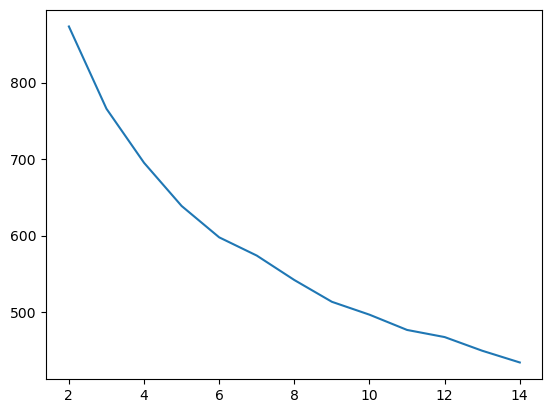

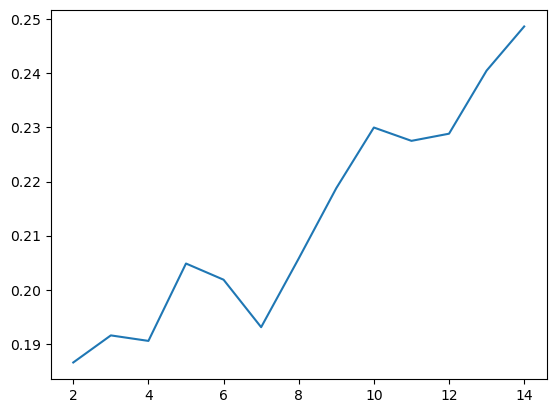

In [5]:
errors = {}
kmeans_results = {}
silhouette_scores = {}
for k in range(2, 15):
    clustered_data = cluster.KMeans(n_clusters=k, max_iter=1000, n_init=20, random_state=42).fit(data)
    kmeans_results[k] = clustered_data
    errors[k] = clustered_data.inertia_
    silhouette_scores[k] = silhouette_score(data, clustered_data.labels_)

plt.plot(list(errors.keys()), list(errors.values()))
plt.show()
plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()))

There is not an obvious elbow in the plot of the mean square errors (top plot). Looking at the silhouette scores, we see there are sharp spikes at 5 and 10. 10 is probably too much, so we'll go with 5.

In [6]:
k = 5

#### Run k-Means

See https://scikit-learn.org/stable/modules/clustering.html for alternative clustering methods.

In [7]:
clustered_data_sklearn = copy.deepcopy(kmeans_results[k])

### E. Apply a manifold-learning technique to project the data set to a 2D space

https://scikit-learn.org/stable/modules/manifold.html

Append the cluster centers to the dataset.

In [8]:
data_and_centers = np.r_[data, clustered_data_sklearn.cluster_centers_]

#### E1. Apply multi-dimensional scaling (MDS) to project both the data and the k-Means cluster centers to a lower dimensional space

Use the elbow method to determine the optimal dimensionality without losing information

https://stackabuse.com/guide-to-multidimensional-scaling-in-python-with-scikit-learn/

Processed with 1 dimensions out of 5
Processed with 2 dimensions out of 5
Processed with 3 dimensions out of 5
Processed with 4 dimensions out of 5
Processed with 5 dimensions out of 5
transformation complete


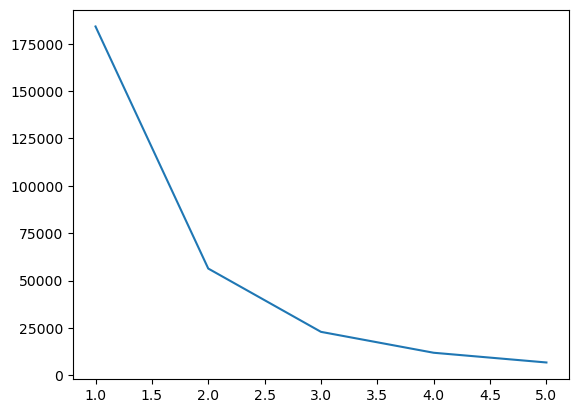

In [9]:
stress = {}
mds_results = {}
max_dims = 6
for dim in range(1, max_dims):
    mds = manifold.MDS(n_components=dim)
    mds_results[dim] = mds.fit_transform(data_and_centers)
    stress[dim] = mds.stress_
    print(f'Processed with {dim} dimensions out of {max_dims - 1}')
    
plt.plot(list(stress.keys()), list(stress.values()))
print("transformation complete")

Copy the best result from above to avoid needing to run it again when testing different dimensions as the above operation is quite slow.

In [19]:
dim = 2
XYcoordinates = copy.deepcopy(mds_results[dim])

Plot the transformed examples and the centers. Use the cluster assignment to colour the examples.

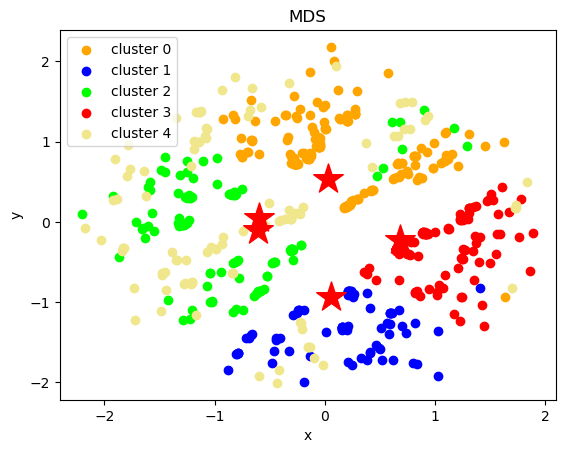

In [20]:
clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustered_data_sklearn.labels_, 
                       centers=XYcoordinates[-k:,:], 
                       title='MDS')

#### E2. Apply t-SNE to project both the data and the k-Means cluster centers to a 2D space

Project both the data and the k-Means cluster centers to 2D.

In [21]:
XYcoordinates = manifold.TSNE(n_components=dim).fit_transform(data_and_centers)
print("transformation complete")

C:\Users\David Ryan\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\David Ryan\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


transformation complete


Plot the transformed examples and the centers. Use the cluster assignment to colour the examples.

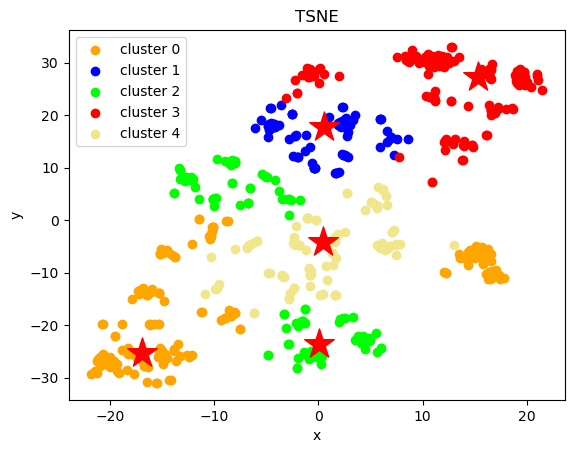

In [22]:
clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustered_data_sklearn.labels_,
                       centers=XYcoordinates[-k:,:], 
                       title='TSNE')

### F. Cluster Analysis

#### Add the cluster labels as an extra column in the original dataframe

In [14]:
df['cluster'] = pd.Series(clustered_data_sklearn.labels_, index=df.index)

In [15]:
for i in range(k):
    print(f'Cluster: {i}')
    df.query(f'cluster == {i}').describe()

Cluster: 0
Cluster: 1
Cluster: 2
Cluster: 3
Cluster: 4


In [16]:
df.tail()

Dependents  ApplicantIncome  LoanAmount  Loan_Amount_Term  \
609    0.000000         0.666409    0.676143             0.750   
610    1.000000         0.858916    0.395858             0.375   
611    0.333333         1.313719    1.566110             0.750   
612    0.666667         1.267616    1.325676             0.750   
613    0.000000         0.925883    1.074155             0.750   

     Credit_History  Gender_Male  Gender_nan  Married_Yes  Married_nan  \
609               1            0           0            0            0   
610               1            1           0            1            0   
611               1            1           0            1            0   
612               1            1           0            1            0   
613               0            0           0            0            0   

     Self_Employed_Yes  Self_Employed_nan  Education_Not Graduate  \
609                  0                  0                       0   
610                  0                  0                       0   
611                  0                  0                       0   
612                  0                  0                       0   
613                  1                  0                       0   

     Property_Area_Semiurban  Property_Area_Urban  Loan_Status_Y  TotalIncome  \
609                        0                    0              1     0.364708   
610                        0                    0              1     0.587496   
611                        0                    1              1     1.116075   
612                        0                    1              1     1.042256   
613                        1                    0              0     0.663523   

     cluster  
609        2  
610        0  
611        0  
612        0  
613        1

#### Compute the mean value of each attribute for each cluster

In [17]:
df.groupby('cluster').mean()

Dependents  ApplicantIncome  LoanAmount  Loan_Amount_Term  \
cluster                                                              
0          0.357815         0.946027    1.123909          0.694209   
1          0.097561         0.928556    1.000477          0.725915   
2          0.078261         0.876531    0.994480          0.735870   
3          0.308642         0.922554    1.119394          0.720741   
4          0.288889         0.893820    1.089010          0.701667   

         Credit_History  Gender_Male  Gender_nan  Married_Yes  Married_nan  \
cluster                                                                      
0              0.994350     0.954802    0.022599     1.000000     0.000000   
1              0.853659     0.548780    0.024390     0.000000     0.024390   
2              0.991304     0.643478    0.008696     0.000000     0.008696   
3              0.985185     0.844444    0.014815     1.000000     0.000000   
4              0.304762     0.828571    0.038095     0.819048     0.000000   

         Self_Employed_Yes  Self_Employed_nan  Education_Not Graduate  \
cluster                                                                 
0                 0.141243           0.067797                0.186441   
1                 0.158537           0.060976                0.207317   
2                 0.104348           0.078261                0.191304   
3                 0.133333           0.029630                0.177778   
4                 0.133333           0.019048                0.361905   

         Property_Area_Semiurban  Property_Area_Urban  Loan_Status_Y  \
cluster                                                                
0                       0.000000             0.598870       0.920904   
1                       1.000000             0.000000       0.707317   
2                       0.000000             0.513043       0.686957   
3                       1.000000             0.000000       0.896296   
4                       0.152381             0.352381       0.009524   

         TotalIncome  
cluster               
0           0.930499  
1           0.783217  
2           0.787636  
3           0.899543  
4           0.845242

#### Conclusion

By looking at the table above we can argue that:
* Cluster 2 are large iris flowers with the largest petals out of the three types.
* Cluster 0 are iris flowers with small petals (notably smaller than the other two types) but with wide sepals, the widest sepals of all three types. This is also the cluster that is clearly differentiated from the other two clusters in the scatter plots.
* Cluster 1 flowers are slightly smaller than cluster 2 flowers with a most notable difference in the width of the petals.

_Note that this conclusion is true for this run of k-Means. If the code is executed again, k-Means may produce either different clusters or the same clusters but in a different order._